In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from bs4 import BeautifulSoup
from urllib.request import urlopen
import datetime

# Functions

In [3]:
def get_close(tickers,
              start=datetime.date(datetime.date.today().year - 1, 
                datetime.date.today().month, 
                datetime.date.today().day)
                ,end=datetime.date.today()):
    
    data=pd.DataFrame()
    for ticker in tickers:

        try:

            yahoo_data=yf.Ticker(ticker)
            stock_price=yahoo_data.history(start=start,end=end,interval='1d').reset_index()
            stock_price['Date']=stock_price['Date'].dt.tz_localize(None)
            stock_price=stock_price.set_index('Date')
            stock_price[ticker]=stock_price['Close']+stock_price['Dividends'].shift(periods=-1)
            data=pd.concat([data,stock_price[ticker]],axis=1)

        except Exception as e:
            pass
        
    return data

In [4]:
def get_mrat(dataframe,numerator=21,denominator=200):

    mrat=(dataframe.rolling(numerator).mean()/dataframe.rolling(denominator).mean())
    mrat_wo_na=mrat.dropna(how='all')

    month=list(sorted(set(mrat_wo_na.index + pd.offsets.BMonthEnd(0))))
    #month_end=pd.to_datetime(mrat_wo_na.index)
    month = pd.to_datetime(month)

    idx1 = pd.Index(mrat_wo_na.iloc[:-1].index)
    idx2 = pd.Index(month)
    closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]


    mrat_weights=mrat_wo_na.loc[closest_dates].copy().fillna(0)
    
    mrat_weights['Total']=mrat_weights.sum(axis=1)

    for col in mrat_weights.columns:
        mrat_weights[col]=mrat_weights[col]/mrat_weights['Total']

    mrat_weights=mrat_weights.drop(columns='Total')
    mrat_weights_dict=mrat_weights.transpose().to_dict()

    dates_end=list(mrat_weights.index)
    dates_end.insert(0,dataframe.index[0])
    dates_end.append(dataframe.index[-1])
    dates_end=list(set(dates_end))
    
    return mrat_weights,sorted(dates_end)

In [5]:
def get_portfolios(mrat_weights,dates_end,dataframe,weight_dict,
                   numbers_of_stocks=50,
                   investment_amount=10000,
                   transaction_fee=0.005):
    tracking={}
    portfolio={}
    initial_amount=investment_amount
    perf=dataframe.pct_change()
    
    for i in range(len(dates_end)-1):
        
        print(dates_end[i],investment_amount,investment_amount/initial_amount)

        
        temp=dataframe.loc[dates_end[i]:dates_end[i+1]].copy()
        initial_price=temp.iloc[0].to_dict()

        if dates_end[i]>dates_end[0]:

            top50=mrat_weights.loc[dates_end[i]].sort_values(ascending=False)[:numbers_of_stocks]
            top_50_rebased=top50/top50.sum()
            top_50_dict=top_50_rebased.to_dict()

            weight_dict={}

            for key in temp.columns:

                if key in top_50_dict: 
                    weight_dict[key]=top_50_dict[key]
                else:
                    weight_dict[key]=0
                    
                    
        weight_vec=np.array(list(weight_dict.values()))
        
        inital_investment_per_stock={}
        shares={}

        for col in temp.columns:
            
            weighted_perf=weight_vec*perf.loc[dates_end[i]]
            
            inital_investment_per_stock[col]=weight_dict[col]*investment_amount*(1+weighted_perf.sum())
            shares[col]=inital_investment_per_stock[col]*(1-transaction_fee)/initial_price[col]

        tracking[dates_end[i]]=(weight_dict,shares,investment_amount,initial_price)

        temp=temp*shares    
        portfolio[dates_end[i]]=temp
        investment_amount=temp.iloc[-1].sum()
        
    
    temp=dataframe.loc[dates_end[-2]:]*shares
    portfolio[dates_end[-1]]=temp
        

    return portfolio,tracking


In [6]:
def get_pnl(portfolios):

    pnl={}

    keys=list(portfolio.keys())
    for i in range(len(keys)):

        if i>0:
            pnl[keys[i]]=portfolio[keys[i]].iloc[-1]-portfolio[keys[i]].iloc[0]

        else:
            
            pnl[keys[0]]=portfolio[keys[0]].iloc[-1]-portfolio[keys[0]].iloc[0]
    
    pnl_dataframe=pd.DataFrame(pnl).cumsum(axis=1).T
    
    return pnl_dataframe.iloc[:-2]

# Dataset

In [8]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
table = pd.read_html(url)
df = table[0]
tickers=df['Symbol'].tolist()

end_date = datetime.datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.datetime(2019,6,15)).strftime("%Y-%m-%d")
#analysis_start_date = (datetime.datetime.now() - datetime.timedelta(days=365*4)).strftime("%Y-%m-%d")

dataframe=get_close(tickers,start=start_date,end=end_date)
dataframe.index=pd.to_datetime(dataframe.index)

$BRK.B: possibly delisted; no timezone found
$BF.B: possibly delisted; no price data found  (1d 2019-06-15 -> 2025-01-31)


In [9]:
sp500=get_close(['SPY'],start=start_date,end=end_date)
sp500_leverage=get_close(['XS2D.L'],start=start_date,end=end_date)

# Analysis

In [11]:
weight_dict={col: 1/dataframe.shape[1] for col in dataframe.columns}
mrat_weights,dates_end=get_mrat(dataframe,numerator=21,denominator=200)

In [12]:
portfolio,tracking=get_portfolios(investment_amount=100,dataframe=dataframe,numbers_of_stocks=15,weight_dict=weight_dict,
                                  mrat_weights=mrat_weights,dates_end=dates_end,
                                  transaction_fee=0.005)

C:\Users\niroo\AppData\Local\Temp\ipykernel_61548\1089267729.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  perf=dataframe.pct_change()


2019-06-17 00:00:00 100 1.0
2020-03-31 00:00:00 83.94281304281049 0.8394281304281048
2020-04-30 00:00:00 100.55864416257326 1.0055864416257325
2020-05-29 00:00:00 108.95102730743398 1.0895102730743398
2020-06-30 00:00:00 116.56311378617895 1.1656311378617894
2020-07-31 00:00:00 133.44212563940934 1.3344212563940934
2020-08-31 00:00:00 148.51496736002684 1.4851496736002685
2020-09-30 00:00:00 145.55070953656093 1.4555070953656093
2020-10-30 00:00:00 143.27898216676954 1.4327898216676953
2020-11-30 00:00:00 164.79448061343373 1.6479448061343374
2020-12-31 00:00:00 174.24060157275895 1.7424060157275896
2021-01-29 00:00:00 183.26378597751966 1.8326378597751967
2021-02-26 00:00:00 197.9498926210627 1.979498926210627
2021-03-31 00:00:00 193.51921139874494 1.9351921139874495
2021-04-30 00:00:00 199.06611531255444 1.9906611531255445
2021-06-01 00:00:00 207.37410938657138 2.073741093865714
2021-06-30 00:00:00 207.0541312495787 2.070541312495787
2021-07-30 00:00:00 208.93386639731528 2.089338663

In [13]:
dates_end[-2],dates_end[-3]

(Timestamp('2025-01-28 00:00:00'), Timestamp('2024-12-31 00:00:00'))

In [14]:
pd.DataFrame(tracking[dates_end[-2]][0].items()).set_index(0).sort_values(by=1,ascending=False).iloc[:20]

,1
0,
PLTR,0.084745
UAL,0.074494
TSLA,0.074160
GEV,0.073058
VST,0.069801
TPR,0.067948
AXON,0.066871
AVGO,0.064388
TPL,0.063851


In [15]:
pd.DataFrame(tracking[dates_end[-3]][0].items()).set_index(0).sort_values(by=1,ascending=False).iloc[:20]

,1
0,
PLTR,0.092830
TSLA,0.079037
UAL,0.074075
AXON,0.073806
VST,0.065581
TPL,0.064110
TPR,0.063682
CCL,0.063263
RCL,0.063097


In [16]:
investment_amount=100
shares={}
for col in dataframe:
    
    shares[col]=(weight_dict[col]*investment_amount)/dataframe.iloc[0][col]

In [17]:
equal_weight=shares*dataframe

In [18]:
pnl=get_pnl(portfolio)
pnl['Total']=pnl.sum(axis=1)
pnl_pct=pnl.copy()

for col in pnl_pct.columns:
    pnl_pct[col]/=pnl_pct['Total']
    
pnl_contrib=pd.DataFrame(pnl_pct.iloc[-1].sort_values(ascending=False))
pnl_amount=pd.DataFrame(pnl.iloc[-1].sort_values(ascending=False))


In [19]:
pnl_contrib

,2024-12-31
Total,1.000000
NVDA,0.106590
SMCI,0.097273
PLTR,0.095628
VST,0.061710
...,...
WBD,-0.010846
NCLH,-0.011269
UHS,-0.012508
CCL,-0.015258


In [20]:
historical_portfolio=pd.DataFrame()
performance=pd.DataFrame()
for key in portfolio.keys():
    historical_portfolio=historical_portfolio.combine_first(portfolio[key])
    

C:\Users\niroo\AppData\Local\Temp\ipykernel_61548\862557853.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  performance_pct=performance_pct.pct_change()


<Axes: >

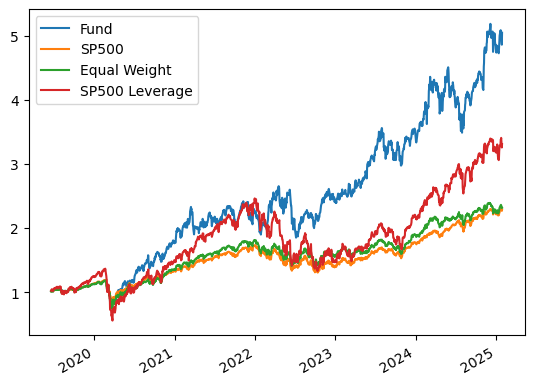

In [21]:
performance['Fund']=historical_portfolio.sum(axis=1)
performance['SP500']=sp500
performance['Equal Weight']=equal_weight.sum(axis=1)
performance['SP500 Leverage']=sp500_leverage

performance_pct=performance.copy()
performance_pct=performance_pct.pct_change()

(1+performance_pct.iloc[:-2]).cumprod().plot()

In [22]:
years=sorted(list(set(performance.index.year)))

In [23]:
month_year=performance.index.strftime('%Y-%m')
month_year=sorted(list(set(month_year)))

In [24]:
(1+performance_pct.loc[str(2025)]).cumprod()

,Fund,SP500,Equal Weight,SP500 Leverage
2025-01-02,0.989191,0.997543,0.998156,0.989125
2025-01-03,1.012642,1.010016,1.013948,0.996917
2025-01-06,1.009111,1.015834,1.017846,1.028380
2025-01-07,0.992397,1.004351,1.009607,1.006377
2025-01-08,0.997098,1.005818,1.011202,0.989421
2025-01-10,0.993043,0.990462,0.995251,0.960260
2025-01-13,0.986985,0.991998,1.000647,0.952278
2025-01-14,1.003540,0.993363,1.008234,0.965370
2025-01-15,1.020045,1.011432,1.022704,0.994763
2025-01-16,1.028726,1.009487,1.029069,1.006377


In [25]:
year_returns={}
for year in years:

    perf_year=performance.loc[str(year)].iloc[-1]/performance.loc[str(year)].iloc[0]-1
    year_returns[year]=perf_year

year_returns[years[-1]]=performance.loc[str(years[-1])].iloc[-2]/performance.loc[str(years[-1])].iloc[0]-1

In [26]:
year_returns_dataframe=pd.DataFrame(year_returns)
year_returns_dataframe

,2019,2020,2021,2022,2023,2024,2025
Fund,0.125486,0.583461,0.260552,0.074122,0.475684,0.416705,0.109113
SP500,0.128370,0.172353,0.305055,-0.186464,0.267092,0.255893,0.029368
Equal Weight,0.125486,0.204699,0.343007,-0.131210,0.216555,0.184131,0.031739
SP500 Leverage,0.232929,0.194817,0.656196,NaN,0.499447,0.484623,0.045514


In [27]:
month_returns={}
for month in month_year:

    perf_year=performance.loc[str(month)].iloc[-1]/performance.loc[str(month)].iloc[0]-1
    month_returns[month]=perf_year

month_returns[month]=performance.loc[str(month_year[-1])].iloc[-2]/performance.loc[str(month_year[-1])].iloc[0]-1

In [28]:
month_returns_dataframe=pd.DataFrame(month_returns)
month_returns_dataframe

,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,...,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01
Fund,0.023039,0.006980,-0.008740,0.027837,0.029054,0.027424,0.036722,-0.007839,-0.086492,-0.196085,...,-0.052632,0.117142,-0.025700,-0.049803,0.081576,0.060032,0.017169,0.210442,-0.051453,0.109113
SP500,0.017469,0.005987,-0.008106,0.025454,0.034408,0.026687,0.037872,-0.009665,-0.085956,-0.161197,...,-0.038647,0.054002,0.034437,0.010030,0.038066,0.042457,0.000035,0.055180,-0.025806,0.029368
Equal Weight,0.023039,0.006980,-0.008740,0.027837,0.029054,0.027424,0.036722,-0.007839,-0.086492,-0.196085,...,-0.050945,0.047424,0.012452,0.030449,0.029364,0.045093,-0.013698,0.074286,-0.064614,0.031739
SP500 Leverage,0.026310,0.034599,-0.064692,0.053049,0.043229,0.058834,0.069655,-0.004618,-0.203045,-0.291766,...,NaN,0.071362,0.086993,0.018843,0.038936,0.054886,0.005852,0.096945,-0.040481,0.045514


In [29]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['SP500']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['SP500'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['SP500'].iloc[-2]/performance['SP500'].iloc[0]
metrics['Sharpe Ratio']=metrics['Fund Return']/metrics['Fund Vol']

In [30]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.476303
Fund Vol,0.522412
Bench Vol,0.203082
Fund Return,5.252188
Bench Return,2.275653
Sharpe Ratio,10.053727


In [31]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['SP500 Leverage']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['SP500 Leverage'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['SP500 Leverage'].iloc[-2]/performance['SP500 Leverage'].iloc[0]
metrics['Sharpe Ratio']=metrics['Fund Return']/metrics['Fund Vol']

In [32]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.547292
Fund Vol,0.522412
Bench Vol,0.363033
Fund Return,5.252188
Bench Return,3.321014
Sharpe Ratio,10.053727


# Manual Testing

initial_price=dataframe.iloc[0].to_dict()
weight_dict={}
inital_investment_per_stock={}
shares={}
initial_amount=100

perf=dataframe.pct_change()
for col in dataframe.columns:
    
    weight_dict[col]=1/dataframe.shape[1]

    inital_investment_per_stock[col]=weight_dict[col]*initial_amount
    shares[col]=inital_investment_per_stock[col]*(1-0.005)/initial_price[col]
    

t=(dataframe*shares).sum(axis=1).loc[dates_end[1]]
i=1
t

top50=mrat_weights.loc[dates_end[i]].sort_values(ascending=False)[:20]
top_50_rebased=top50/top50.sum()
top_50_rebased=top_50_rebased.to_dict()

inital_investment_per_stock={}
initial_investment=t
shares={}
initial_price=dataframe.loc[dates_end[i]].to_dict()
#tracking[1][3]

weight_dict={}

for col in dataframe.columns:    

    if col in top_50_rebased:
        
        weight_dict[col]=top_50_rebased[col]
    else:
        weight_dict[col]=0
        
weight_vec=np.array(list(weight_dict.values()))


for col in dataframe.columns:    

    inital_investment_per_stock[col]=weight_dict[col]*initial_investment*(1+(perf.loc[dates_end[i]]*weight_vec).sum())
    shares[col]=inital_investment_per_stock[col]*(1-0.005)/initial_price[col]

i=i+1

t=(dataframe*shares).sum(axis=1).loc[dates_end[i]]
t